In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

(549, 976, 3)


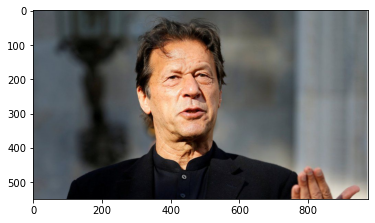

In [2]:
path = "./test_images/imran_khan.jpg"
img = cv2.imread(path)
print(img.shape)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

(549, 976)


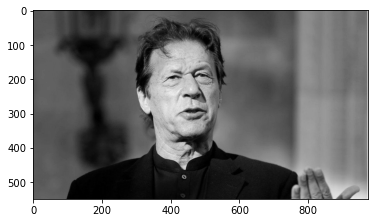

In [3]:
#converting image to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(gray.shape)
plt.imshow(gray,cmap = "gray")

In [4]:
gray

array([[ 92,  91,  89, ...,  99, 169, 252],
       [ 91,  90,  89, ..., 100, 170, 253],
       [ 91,  90,  89, ..., 101, 171, 254],
       ...,
       [ 97,  97,  97, ..., 215, 228, 253],
       [ 97,  97,  97, ..., 216, 229, 254],
       [ 97,  97,  97, ..., 216, 229, 254]], dtype=uint8)

In [5]:
# using harcascade to detect eyes and face
face_cascade = cv2.CascadeClassifier( './opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye_tree_eyeglasses.xml')
# detectmultiscale is used to detect objects in images
# https://stackoverflow.com/questions/22249579/opencv-detectmultiscale-minneighbors-parameter
faces = face_cascade.detectMultiScale(gray,1.3,3)
print(faces) # gives (x,y,w,h) values
#?cv2.CascadeClassifier.detectMultiScale

[[341 100 238 238]]


In [6]:
print(faces[0])
print(faces[0][0])

[341 100 238 238]
341


In [7]:

(x,y,w,h) = faces[0]
x,y,w,h

(341, 100, 238, 238)

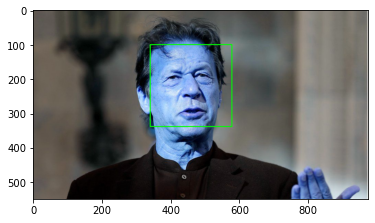

In [8]:
face_img = cv2.rectangle(img = img,pt1 = (x,y),pt2 = (x+w,y+h),color = (0,255,0),thickness = 2)
plt.imshow(face_img)

2


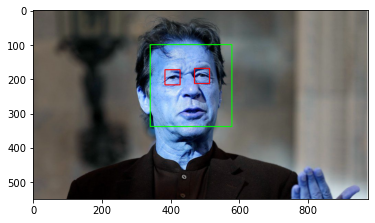

In [9]:
cv2.destroyAllWindows()

for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = face_img[y:y+h,x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray,1.1,3)
    print(len(eyes))
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(255,0,0),2)

plt.figure()
plt.imshow(face_img,cmap = "gray")
plt.show()


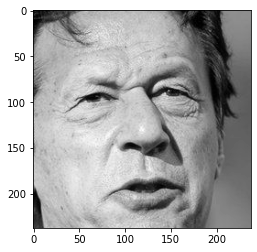

In [10]:
plt.imshow(roi_gray,cmap = "gray")
plt.show()

In [11]:
def get_cropped_face(img_path):
    #print(img_path)
    img = cv2.imread(img_path)
    if img is not None:
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray,1.3,3)
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h,x:x+w]
            roi_color = img[y:y+h,x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                return roi_color


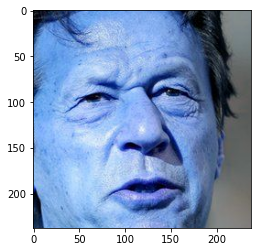

In [12]:
cropped_face = get_cropped_face('./test_images/imran_khan.jpg')
plt.imshow(cropped_face)

In [13]:
cropped_face = get_cropped_face('./test_images/copy.jpg')
cropped_face

In [14]:
path_to_images = "./dataset/"
path_to_cropped_images = "./dataset/cropped/"

In [15]:
import os
img_dir = []
#os.scandir is used to iterate directory and sub directory
for entry in os.scandir(path_to_images):
    print(entry)
    print(entry.path)
    if entry.is_dir():
        img_dir.append(entry.path)

<DirEntry 'asif_zardari'>
./dataset/asif_zardari
<DirEntry 'cropped'>
./dataset/cropped
<DirEntry 'imran_khan'>
./dataset/imran_khan
<DirEntry 'shahbaz_sharif'>
./dataset/shahbaz_sharif
<DirEntry 'sheikh_rasheed'>
./dataset/sheikh_rasheed


In [16]:
img_dir

['./dataset/asif_zardari',
 './dataset/cropped',
 './dataset/imran_khan',
 './dataset/shahbaz_sharif',
 './dataset/sheikh_rasheed']

In [17]:
# if cropped folder exists delete it first and then re create folder
import shutil
if os.path.exists(path_to_cropped_images):
    shutil.rmtree(path_to_cropped_images)
os.mkdir(path_to_cropped_images)

In [18]:
# Adding cropped images in respected folders
path_to_cropped_images = "./dataset/cropped/"
cropped_image_dirs = []
politican_file_names_dict = {}
for folder_path in img_dir:
    count = 1
    #print(folder_path)
    politician_name = folder_path.split('/')[-1]
    cropped_politician_path = path_to_cropped_images + politician_name
    if politician_name != "cropped":
        #print(politician_name)
        print(f"Reading {politician_name} images ....")
        cropped_image_dirs.append(cropped_politician_path)
        politican_file_names_dict[politician_name] = []
        if not os.path.exists(cropped_politician_path):

            os.mkdir(cropped_politician_path)
            for images in os.scandir(folder_path):
                #print(images)
                #print(images.path)
                roi_color = get_cropped_face(images.path)
                if roi_color is not None:
                    cropped_img_name = politician_name + str(count) + '.png'
                    cropped_face_path = cropped_politician_path + '/'+cropped_img_name
                    cv2.imwrite(cropped_face_path,roi_color)
                    politican_file_names_dict[politician_name].append(cropped_face_path)
                    count += 1

             

        

Reading asif_zardari images ....
Reading imran_khan images ....
Reading shahbaz_sharif images ....
Reading sheikh_rasheed images ....


<h3 style='color:purple'>(3) Preprocessing: Use wavelet transform as a feature for traning our model</h3>

#### In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

In [19]:
#https://www.youtube.com/watch?v=Qryd7z9k8i4&t=0s
import pywt
# wavelet transform is used to find features in signal using decomposition and then reconstructing the signal
def w2d(img,mode = "haar",level = 1):
    imgArray = img
    #convert to grayscale
    imgArray = cv2.cvtColor(imgArray,cv2.COLOR_BGR2GRAY)
    #convert to float
    imgArray = imgArray.astype(np.float64)
    #scaling the image
    imgArray = imgArray / 255
    #decomposing the signal
    coeffs = pywt.wavedec2(imgArray,mode,level = level)
    #print(coeffs)
    #process coefficients
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    #reconstructing the signal back in original form
    imgArray_H = pywt.waverec2(coeffs_H,mode)
    imgArray_H *= 255
    imgArray_H = imgArray_H.astype(np.uint8)
    return imgArray_H 




(150, 150, 3)


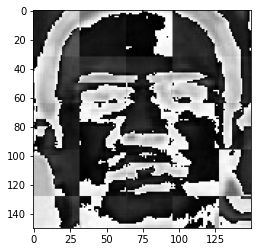

In [21]:
cropped_image = cv2.imread('./dataset/cropped/asif_zardari/asif_zardari10.png')
cropped_image = np.array(cropped_image)
print(cropped_image.shape)
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har,cmap = "gray")


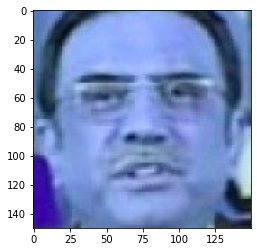

In [22]:
cropped_image = cv2.imread('./dataset/cropped/asif_zardari/asif_zardari10.png')
plt.imshow(cropped_image)

#### You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

In [23]:
# Getting Y by assigning numbers to dict keys of politican name
class_dict = {}
count = 0
for key,values in politican_file_names_dict.items():
    class_dict[key] = count
    count += 1
    #print(values)

class_dict


{'asif_zardari': 0, 'imran_khan': 1, 'shahbaz_sharif': 2, 'sheikh_rasheed': 3}

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [24]:
X ,y = [],[]
for poli_name,image_files in politican_file_names_dict.items():
    for image in image_files:
        img = cv2.imread(image)
        if img is not None:
            scaled_raw_image = cv2.resize(img,(32,32))
            img_har = w2d(img,"db1",5)
            scaled_img_har = cv2.resize(img_har,(32,32))
            # converting colored image in 2D array of (32*32*3,1) here 3 are channels BGR
            scaled_raw_image_2D = scaled_raw_image.reshape((32*32*3,1))
            # converting feature(black and white) image in 2D array of (32*32,1)
            scaled_img_har_2D = scaled_img_har.reshape((32*32,1)) 
            combined_img = np.vstack((scaled_raw_image_2D,scaled_img_har_2D))
            X.append(combined_img)
            y.append(class_dict[poli_name])

In [25]:
len(X)

222

In [26]:
len(X[0])

4096

In [27]:
32*32*3 + 32*32

4096

In [28]:
X[0]

array([[66],
       [83],
       [83],
       ...,
       [49],
       [39],
       [39]], dtype=uint8)

In [29]:
y[0]

0

In [31]:
X = np.array(X).reshape((len(X),4096)).astype(float)
X.shape

(222, 4096)

In [39]:
df = pd.DataFrame(data = X,columns = ['f'+str(i) for i in range(X.shape[1])])
df['class'] = y
df.to_csv('dataset.csv',index = False)


In [37]:
X.shape[1]

4096

In [41]:
#saving classes dictionary
import joblib 
joblib.dump(class_dict,'class_dict.joblib')


['class_dict.joblib']

In [42]:
classes = joblib.load('class_dict.joblib')
classes

{'asif_zardari': 0, 'imran_khan': 1, 'shahbaz_sharif': 2, 'sheikh_rasheed': 3}